
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


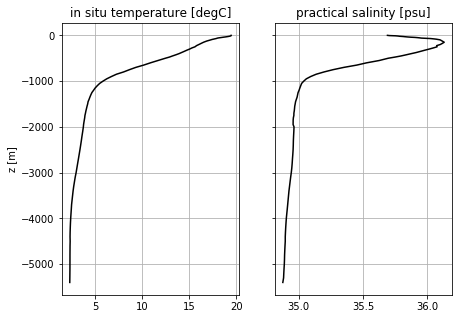

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma=compute_gamma(f.a,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
#f.init_piston(vol_min=vmin,vol_max=vmax,vol=vmax)
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

131.8 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  a     = 0.06 m      - float radius
  m     = 5.79 kg     - float radius
  V     = 5.65e+03 cm^3   - float volume
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
Piston parameters and state: 
  a     = 2.50 cm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 cm        - present piston displacement
  vol   = 114.48 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  phi_max = 2513.27 deg     - maximum rotation
  phi_min = 0.00 deg     - minimum rotation
  d_max = 7.00 cm        - maximum piston displacement
  d_min = 0.00 cm        - minimum piston displacement
  vol_min = -22.97 cm^3    - min volu

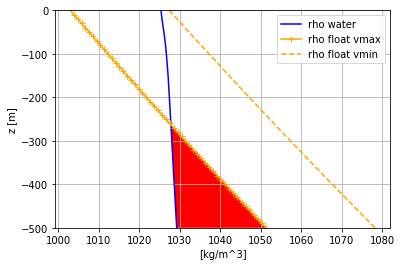

In [4]:
# show densities
plot_float_density(z, f, w)

---

## From the surface down to a target level

In [5]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 47.2 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [6]:
# time step float with control
control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#
f.time_step(w,T=1800., dt_step=.1, dt_store=1., z=0., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control)

{'tau': 10.0, 'dz_nochattering': 1.0, 'mode': 'sliding', 'd3y_ctrl': 0.44568518451009714}
Start time stepping for 30 min ...
... time stepping done


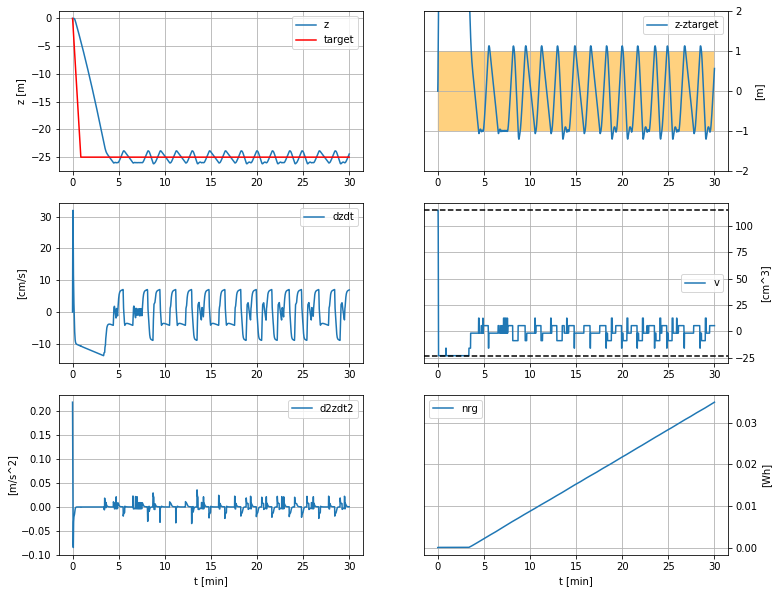

In [7]:
# plot log
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [8]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [9]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

{'tau': 10.0, 'dz_nochattering': 1.0, 'mode': 'sliding', 'd3y_ctrl': 0.44568518451009714}
Start time stepping for 30 min ...
... time stepping done


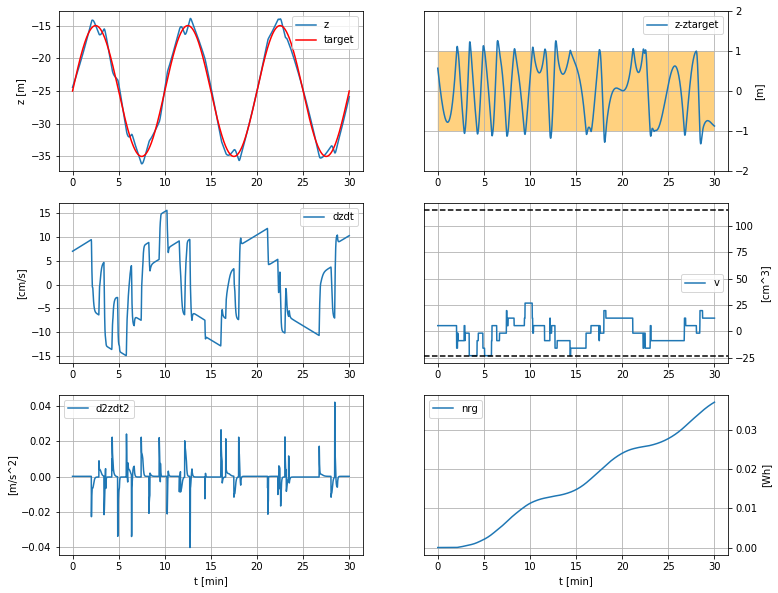

In [10]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [11]:
eta = lambda t: 20.*np.sin(2.*np.pi/600.*t)
z_target = lambda t: -25.+t*0.

In [12]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

{'tau': 10.0, 'dz_nochattering': 1.0, 'mode': 'sliding', 'd3y_ctrl': 0.44568518451009714}
Start time stepping for 30 min ...
... time stepping done


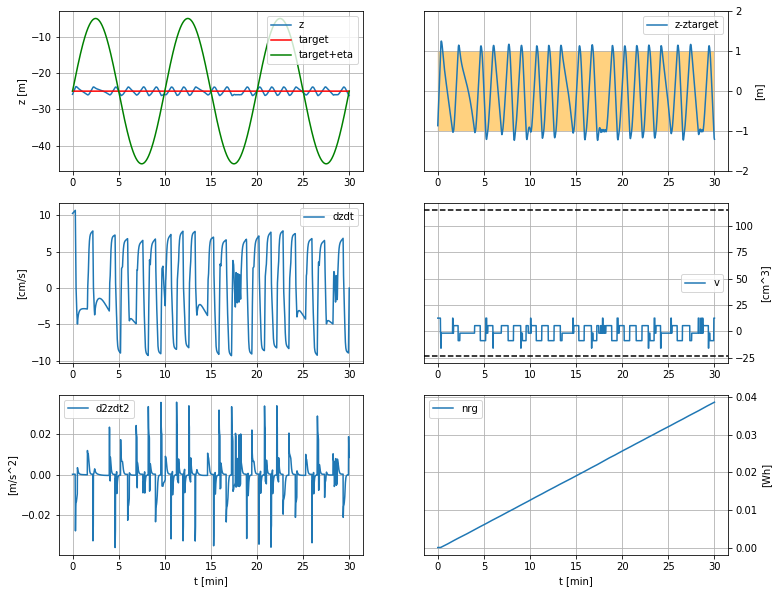

In [13]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [14]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

Start time stepping for 30 min ...
... time stepping done


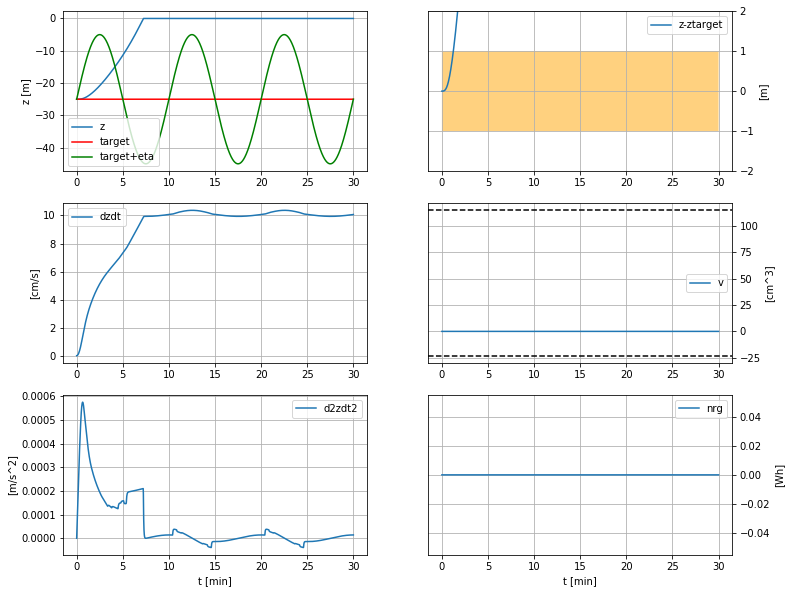

In [15]:
plot_log(f, z_target=z_target, eta=eta)